# iLykei Lecture Series
# Advanced Machine Learning and Artificial Intelligence (MScA 32017)

# Project: Detection of Toxic Comments Online

## Notebook 3: Wine Reviews Example

## Yuri Balasanov, Leonid Nazarov, &copy; iLykei 2018

This notebook describes multiclass classification based on text description: problem similar to the main project. 

Data for this document can be downloaded from the [Kaggle competition web site](https://www.kaggle.com/christopheiv/winemagdata130k).

The goal is to identify wine producing country by analyzing text from a sommelier describing the wine's taste, smell, look, feel, etc.

# Word embeddings and preparation

Load the data.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
from os.path import expanduser
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

dataPath = expanduser("~/Datasets/32017/")
reviews = pd.read_csv(dataPath+"winemag-data-130k-v2.csv", index_col=0)
reviews.head()


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Count number of wines from each country.

In [3]:
reviews.country.value_counts().head()

US          54504
France      22093
Italy       19540
Spain        6645
Portugal     5691
Name: country, dtype: int64

The goal of the project is building a model separating US wines from Italian ones based on the reviews. 

Reduce data set leaving only US and Italian wines in it. 

In [4]:
Countries = ['US','Italy']
reviews = reviews[np.isin(reviews.country,Countries)][['description','country']]
reviews['country'] = LabelEncoder().fit_transform(reviews.country)

## Embedding index

Create FastText embeddings index from file `*crawl-300d-2M.vec*` with FastText word vectors as shown in [MScA_32017_AMLAI_TC1_NLP_Basics.ipynb](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FToxicComments%2FMScA_32017_AMLAI_TC1_NLP_Basics.ipynb).  

Recall that the first line of the file contains the number of words in the vocabulary and the size of the vectors. Each line contains a word followed by its vector, like in the default fastText text format. Each value is space separated. Words are ordered by descending frequency.  

Create dictionary with words as keys and embeddings as values.

In [6]:
# Create embedding index from file in .txt format. First line contains 
# dictionary size and embedding dim. Fields are space separated
def get_embeddings(file_name):
    embeddings_index = {}
    with open(file_name, encoding="utf8") as f:
        for line in f:
            values = line.rstrip().split(' ')
            if len(values) > 2:
                embeddings_index[values[0]] = np.asarray(values[1:], dtype="float32")
    return embeddings_index
embeddings_path = expanduser('~/Datasets/text_embeddings/')
embeddings_index = get_embeddings(embeddings_path+'crawl-300d-2M.vec')

## Remove unnecessary tokens

The function in the next cell replaces punctuation marks (except apostrophe), digits, Carriage Return and Line Feed symbols with space. Then several consecutive spaces are replaced with single one. Replacing with method `translate()` is very fast.

In [7]:
import string
trans_table = str.maketrans({key: ' ' for key in string.digits + '\r\n' +
                             string.punctuation.replace("\'",'')})
def preprocess(text):
    return ' '.join(text.lower().translate(trans_table).split(' '))

Use `preprocess()` to preprocess comments and remove rare words.
Create vocabulary of words that occur more than 5 times.
To count occurrences use `CountVectorizer` which converts a collection of text documents into a matrix of token counts.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

UNKNOWN_PROXY = 'unknown'
MIN_WORD_OCCURRENCE = 5

reviews['description'] = reviews.description.apply(preprocess)
print("Creating the vocabulary of words occurred more than", MIN_WORD_OCCURRENCE)

vectorizer = CountVectorizer(lowercase=False, token_pattern="\S+", 
                             min_df=MIN_WORD_OCCURRENCE)
vectorizer.fit(reviews.description)

top_words = set(vectorizer.vocabulary_.keys())
top_words.add(UNKNOWN_PROXY)
print(len(top_words),'top words')

Creating the vocabulary of words occurred more than 5
9366 top words


Check the first 10 words in the vocabulary `top_words`.
Also check that added word "unknown" belongs to `top_words`.  

In [9]:
print('First 10 out of "top_words": \n',list(top_words)[:10])
print('\nIs "unknown" in top_words? \n','unknown' in top_words)

First 10 out of "top_words": 
 ['remaining', 'neive', 'predictably', 'claim', 'aerate', 'onward', 'button', 'ben', 'umpqua', 'carignano']

Is "unknown" in top_words? 
 True


<font color=blue>
    
**Assignment** <br>
Replace all words in `reviews['description']` that do not belong to the intersection of `top_words` and `embeddings_index.keys()` with `UNKNOWN_PROXY`.

Create function `filter_unknown(text, vocabulary, proxy)` which does that.

In [10]:
# Skipped code
# Function filter_unknown()


In [11]:
# Skipped code
# Remove

def filter_unknown(text, vocabulary, proxy):
    return ' '. \
join([w if w in vocabulary else proxy for w in text.split(' ')])

Apply the function to the variable of reviews.

In [12]:
reviews['description'] = reviews.description.apply(filter_unknown,
                args=(set(embeddings_index.keys() & top_words), \
                      UNKNOWN_PROXY))

In [13]:
reviews['description'][0]

"aromas include tropical fruit unknown broom unknown brimstone and dried herb unknown the palate isn't overly expressive unknown offering unknown apple unknown citrus and dried sage alongside brisk acidity unknown"

## Tokenization

Tokenize reviews by Keras preprocessing classes

`Tokenizer`: Class allowing to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...

`fit_on_texts()`: Method of `Tokenizer` that updates internal vocabulary based on a list of texts.
Required before using `texts_to_sequences()` or `texts_to_matrix()`.

In [14]:
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding

/Users/rowena/miniconda3/envs/msca/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Word index

Fit tokenizer: create `word_index` of words in the corpus.

In [15]:
tokenizer = Tokenizer(filters="")
tokenizer.fit_on_texts(reviews.description)
print(tokenizer)

Result of `fit_on_texts()` is `word_index` - list of tuples  with words and their index values.

In [16]:
word_index = tokenizer.word_index
print(len(word_index))
list(word_index.items())[:16]

8678


[('unknown', 1),
 ('and', 2),
 ('the', 3),
 ('of', 4),
 ('a', 5),
 ('with', 6),
 ('this', 7),
 ('is', 8),
 ('in', 9),
 ('wine', 10),
 ('flavors', 11),
 ('to', 12),
 ('it', 13),
 ('fruit', 14),
 ('on', 15),
 ('aromas', 16)]

# Input data for network

Prepare input data for neural network.

Method `texts_to_sequences()` turns each text into a sequence of based on `word_index` integers. Integers are index values in `word_index`: check the first review, it starts with "aroma". That word is #16 in `word_index`. The first integer in the first list of `seq` is 16.

Method `pad_sequences()` pads sequences to the same lengths.

Dump data into file `wine_data.pkl`.

In [17]:
MAX_SEQUENCE_LENGTH = 50
seq = tokenizer.texts_to_sequences(reviews.description)
data = pad_sequences(seq,maxlen=MAX_SEQUENCE_LENGTH,padding='post',
                     truncating='post')
with open(dataPath + 'wine_data.pkl','wb') as f: pickle.dump(data, f, -1)

print('\nFirst 2 sequences in `seq`: ',seq[:2])
print('\nShape of `data`: ',data.shape)
print('\nFirst prepared text in `data`:',data[0])


First 2 sequences in `seq`:  [[16, 892, 223, 14, 1, 1398, 1, 2587, 2, 61, 71, 1, 3, 17, 904, 1216, 784, 1, 250, 1, 58, 1, 77, 2, 61, 276, 82, 294, 24, 1], [88, 2, 1891, 1, 3, 11, 4, 137, 922, 2, 612, 895, 1, 97, 94, 194, 5021, 66, 1, 6, 70, 24, 4218, 3, 11, 1, 3, 10, 321, 102, 557, 542, 382, 1]]

Shape of `data`:  (74044, 50)

First prepared text in `data`: [  16  892  223   14    1 1398    1 2587    2   61   71    1    3   17
  904 1216  784    1  250    1   58    1   77    2   61  276   82  294
   24    1    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


## Prepare embedding matrix

In function `get_embedding_matrix()` below the following combination of iterator `iter()` and method `next()` allow sequentially moving through iterable object as in this simple example:

In [18]:
mlist=['word_1','word_2','word_3']
moveIter=iter(mlist)
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))

word_1
word_2
word_3
enough
enough


Below iterator is used to find length of the first row of values of `embeddings_index`:

In [19]:
embeddings_dim = len(next(iter(embeddings_index.values())))
embeddings_dim

300

Note that this is necessary because values of a dictionary have no attribute `shape`, so `embeddings_index.values().shape` will not work.

The following function `get_embedding_matrix()` makes embedding matrix from `word_index` and `embeddings_index` obtained above. <br>

Embedding matrix shape is `(len(word_index) + 1,embeddings_dim)`. <br>

Row number $i$ of the embedding matrix contains embedding vector of the word whith index in `word_index` equal to $i$.

In [20]:
# Create embedding matrix
def get_embedding_matrix(word_index,embeddings_index):
    nb_words = len(word_index) + 1 # +1 since min(word_index.values())=1
    embedding_matrix = np.zeros((nb_words,embeddings_dim))
    unknown = 0
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is None: unknown += 1
        else: embedding_matrix[i] = embedding_vector
    return embedding_matrix, unknown

# Embedding layer

Now preparation of the data is finished. It is possible to start building model. But it is common and convenient to create embedding layer and save it beforehand. 
This helpes separating data preparation and network fitting. 
Then only two files are necessary to run the network: `wine_data.pkl` and the embedding layer, both saved earlier.

In text processing networks embedding layer comes first after the input layer. It transforms sequences of integers (word indices) to sequences of correspondent embedding vectors using embedding matrix.

The function below creates and saves  embedding layer. Setting `trainable=False` means that the weights of this layer (actually the elements of embedding matrix) will not be changed during model training. 

In [21]:
# Create embedding_layer and save it.
def make_save_emb_layer(word_index,embeddings_index,layer_file_name):
    embedding_matrix,unknown = get_embedding_matrix(word_index,embeddings_index)
    embedding_layer = Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],
                                weights=[embedding_matrix],trainable=False)
    with open(layer_file_name,'wb') as f: 
        pickle.dump(embedding_layer, f, -1)
    return unknown

EMBEDDING_LAYER_FILE = dataPath + 'wine_embed_layer.pkl'
print(make_save_emb_layer(word_index,embeddings_index,EMBEDDING_LAYER_FILE),
      'unknown words')

0 unknown words


# Model

The following architecture of the model was used in the competition by several participans.

In [22]:
from keras.layers import Dense,Embedding,Input,Dropout,Conv1D
from keras.layers import SpatialDropout1D, Flatten,LSTM
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import roc_auc_score
from keras.utils import plot_model


def get_model():
    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embedding_layer(input_layer)
    x = SpatialDropout1D(0.5)(x)
    x = LSTM(10, return_sequences=True)(x)
    x = Conv1D(5, kernel_size=2, padding="valid")(x)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dropout(.2)(x)
    output_layer = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss="binary_crossentropy", optimizer=Adam())
    return model


Load the data and the pre-saved embedding layer.
Split data into train and validation sets.

In [23]:
with open(EMBEDDING_LAYER_FILE, 'rb') as f: embedding_layer = pickle.load(f)
with open(dataPath + 'wine_data.pkl', 'rb') as f: data = pickle.load(f)   

X_train, X_test, y_train, y_test = train_test_split(data, reviews.country, 
                    test_size=0.2, stratify = reviews.country, random_state=0)


Set parameters, build and summarize the model.

In [24]:
best_model_path = 'best_model.h5'
BATCH_SIZE = 512

early_stopping = EarlyStopping(patience=2)
model_checkpoint = ModelCheckpoint(best_model_path,
                                   save_best_only=True, save_weights_only=True)
model = get_model()
print(model.summary())
plot_model(model, to_file='wine_reviews.png',show_shapes=True,show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           2603700   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 10)            12440     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 49, 5)             105       
_________________________________________________________________
flatten_1 (Flatten)          (None, 245)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 245)               980       
__________

![WineReviewsModel](wine_reviews.png)

Train the model and validate it.

In [24]:
hist = model.fit(X_train, y_train,validation_data=(X_test, y_test),
                 epochs=28, batch_size=BATCH_SIZE, shuffle=True, verbose=2,
                 callbacks=[model_checkpoint, early_stopping])
model.load_weights(best_model_path)
test_pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
print('validation AUC',roc_auc_score(y_test, test_pred))

Train on 59235 samples, validate on 14809 samples
Epoch 1/28
 - 31s - loss: 0.5523 - val_loss: 0.2676
Epoch 2/28
 - 18s - loss: 0.2866 - val_loss: 0.3000
Epoch 3/28
 - 17s - loss: 0.1996 - val_loss: 0.1981
Epoch 4/28
 - 17s - loss: 0.1631 - val_loss: 0.1462
Epoch 5/28
 - 17s - loss: 0.1405 - val_loss: 0.1206
Epoch 6/28
 - 17s - loss: 0.1284 - val_loss: 0.0867
Epoch 7/28
 - 17s - loss: 0.1217 - val_loss: 0.0816
Epoch 8/28
 - 17s - loss: 0.1120 - val_loss: 0.0732
Epoch 9/28
 - 19s - loss: 0.1066 - val_loss: 0.0697
Epoch 10/28
 - 17s - loss: 0.0993 - val_loss: 0.0768
Epoch 11/28
 - 17s - loss: 0.0970 - val_loss: 0.0724
validation AUC 0.9945266681796163


Plot history of loss and validation loss.

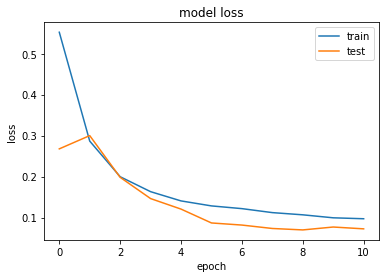

In [25]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

<font color=blue>
    
**Assignment** <br>
Run the same model for data set including only US and French wines. Calculate validation AUC for it. Which vines are closer to US ones according to the model?

In [ ]:
# Remove
# Answer: French. Validation AUC for them is less than 0.99. So it is easier for the model to solve binary classification problem with 'Italy' as alternative to 'US'.

# Words Polarity Analysis

Analyze words polarity like in [MScA_32017_AMLAI_TC2_DataOverview.ipynb](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FToxicComments%2FMScA_32017_AMLAI_TC2_DataOverview.ipynb)

Create tf-idf features for words from train data set comments with the following settings: max_features=50000, min_df=5, max_df=0.9.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=50000, min_df=5, max_df=0.9)
X = tfidf.fit_transform(reviews.description)

Fit logistic regression model taking these features as regressors and 'country' as target variable.

In [27]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X, reviews['country'].values)

/home/yuri/anaconda3/envs/newtf/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Make data frame *polarity* with index containing all words from *TfidfVectorizer* *vocabulary_.keys()* and two columns. First of them contains corresponding  *vocabulary_.values()*, the second one - logistic regression coefficients.

In [28]:
polarity = pd.DataFrame.from_dict(tfidf.vocabulary_,orient='index')\
                                                    .sort_values(0)
polarity['coef'] = lr.coef_[0]

Sort data frame *polarity* according to coefficient value. Find 30 words with maximal coefficients and 30 words with minimal coefficients. Plot their coefficients with horizontal bars.

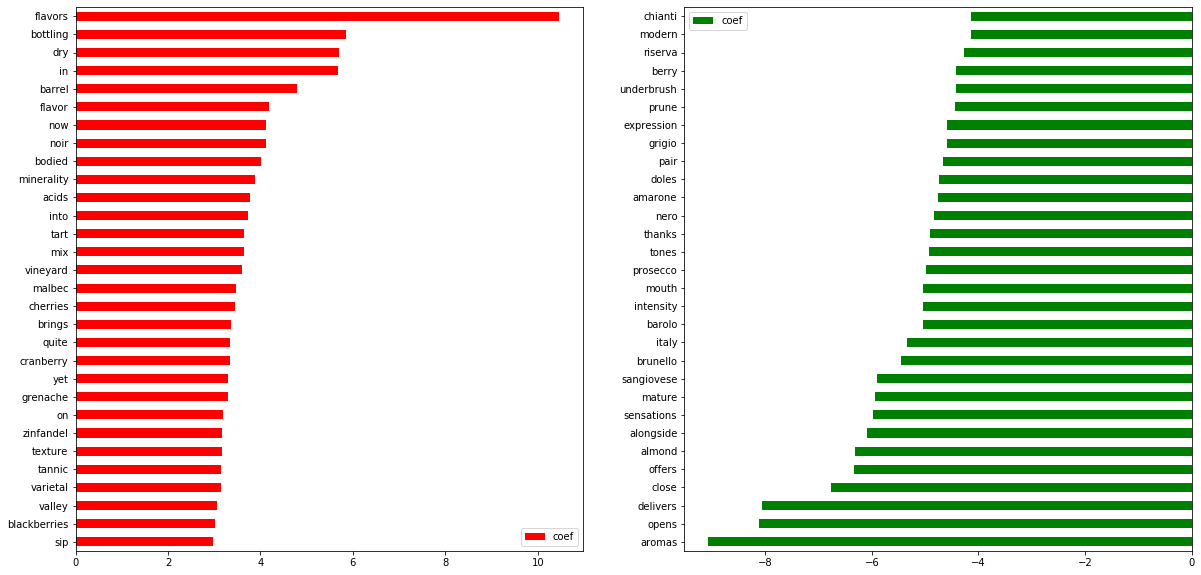

In [29]:
from matplotlib import pyplot as plt
polarity.sort_values('coef',inplace=True)
plt.figure(figsize=(20, 10))
ax = plt.subplot(1,2,1)
polarity[['coef']].tail(30).plot(kind='barh', color='red', ax=ax)
ax = plt.subplot(1,2,2)
polarity[['coef']].head(30).plot(kind='barh', color='green', ax=ax)

Words from the right green plot correspond to Italian wines.